In [1]:
import SIMSIToolBox
import seaborn as sb
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams['figure.dpi'] = 200
import os
import pandas as pd
import numpy as np
from scipy.interpolate import interp1d
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
from copy import deepcopy

In [2]:
datadir = "X:/MSI_Shared_Data/13CImagingManuscript/raw_data/imzmls/subset_data/NA_corrected_data/manuscript_figs/figure4/"

In [3]:
formula = "C16H31O2" #should be the adducted form of the metabolite (protenated or deprotenated)
polarity="negative"
num_cores=10
ppmThresh = 50
colormap = "CMRmap" #coloring for images, see https://matplotlib.org/3.1.1/gallery/color/colormap_reference.html

colormap = LinearSegmentedColormap.from_list("test",colors=["black", "navy","blue","cyan","yellow","orange","orangered","red","mistyrose","white"],N=256)


def cmap_custom(val,alpha,minim,maxim):
    
    val_norm = (val - minim) / (maxim - minim)
    
    #rgba mapping
    r = interp1d([0,.5,1.0],[0,.5,1.0])
    g = interp1d([0,.5,1.0],[0.0,0.0,0.0])
    b = interp1d([0,.5,1.0],[0.0,0.0,0.0])
    
    return (r(val_norm),g(val_norm),b(val_norm),alpha)

def apply_cmap(arr,alpha):
    sh = arr.shape
    arr = arr.flatten()
    minim = np.min(arr)
    maxim = np.max(arr)
    arr = np.array([cmap_custom(x,alpha,minim,maxim) for x in arr])
    arr = arr.reshape(list(sh) + [arr.shape[1]])
    return arr



In [4]:
files = [x for x in os.listdir(datadir) if ".csv" in x]# and formula in x]
files

['20210223_02_100w120h_13CtumorBrain2_009109H_01 009109H_1.csv',
 '20210223_02_100w120h_13CtumorBrain2_009109H_01 009109H_1_C16H31O2.csv',
 '20210301_02_90w115h_13CnontumorBrain5_02824A_01 02824A_1.csv',
 '20210301_02_90w115h_13CnontumorBrain5_02824A_01 02824A_1_C16H31O2.csv']

In [13]:
file = files[1]

In [14]:
m0Mz,mzsOI,numCarbons = SIMSIToolBox.getMzsOfIsotopologues(formula,elementOfInterest="C")
msi = SIMSIToolBox.MSIData(mzsOI,ppm=ppmThresh,numCores = num_cores,intensityCutoff=0)
df = pd.read_csv(datadir + file,index_col=0)
msi.from_pandas(df,polarity)

In [40]:
try: os.mkdir(datadir + file.replace(".csv","/"))
except: pass

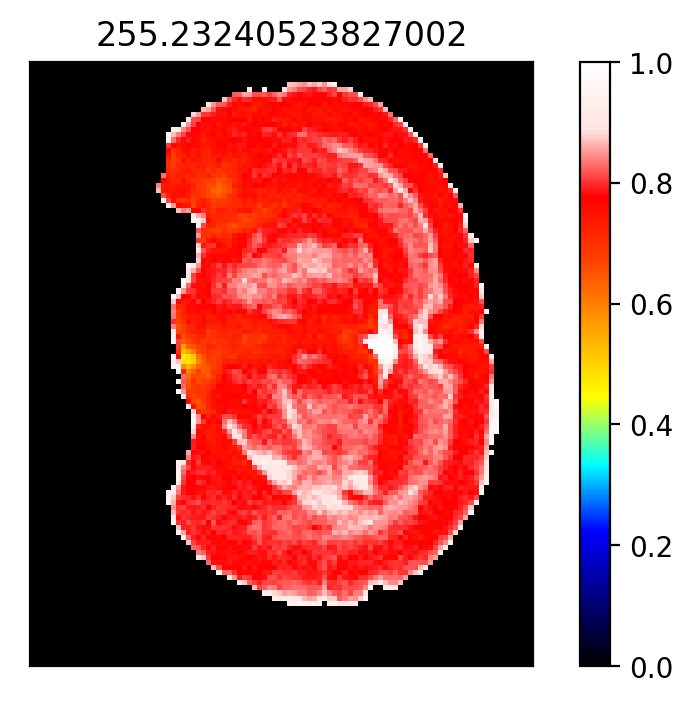

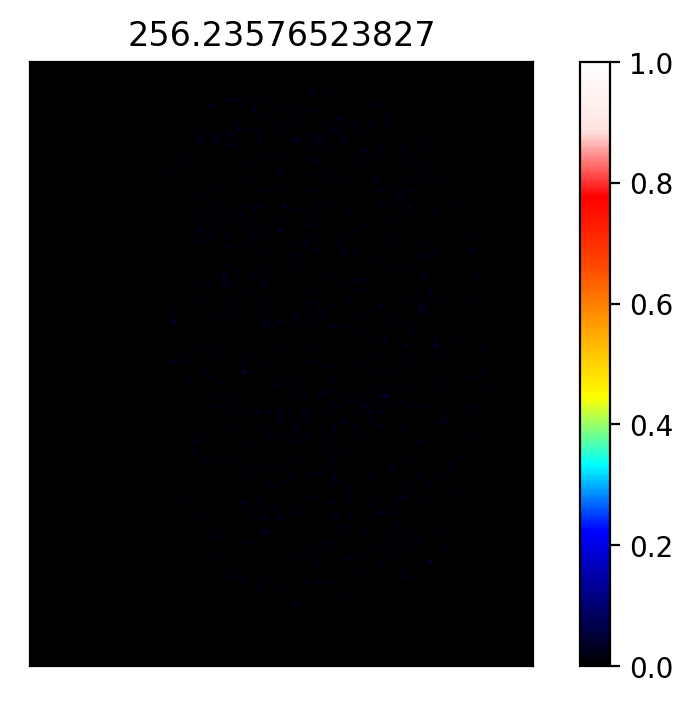

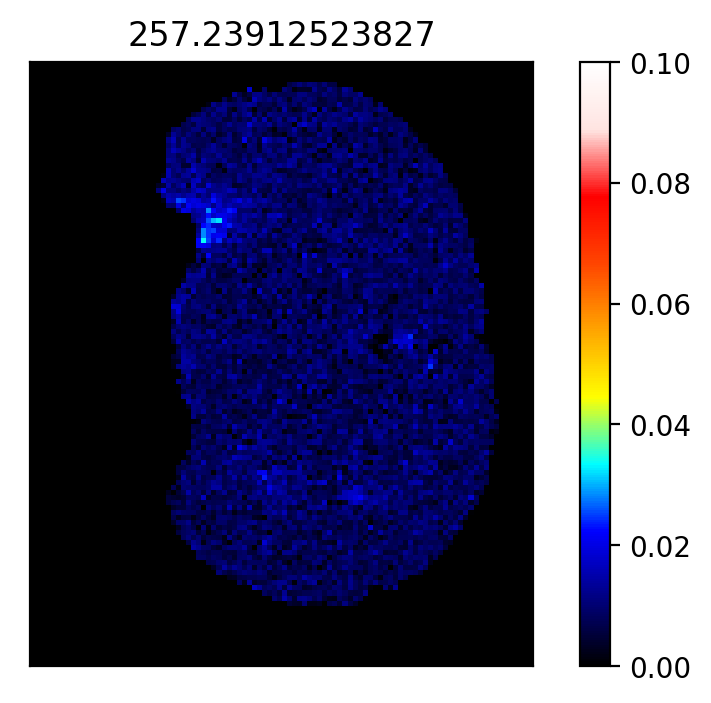

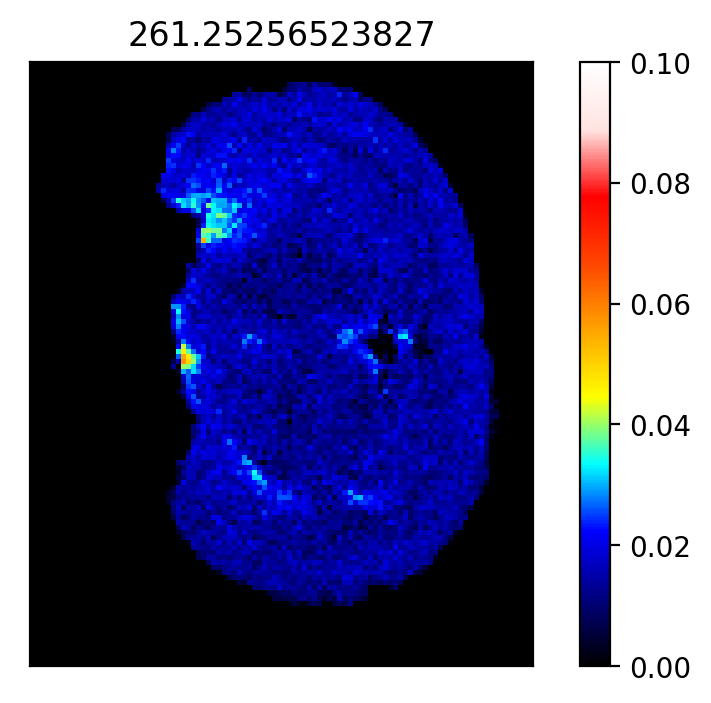

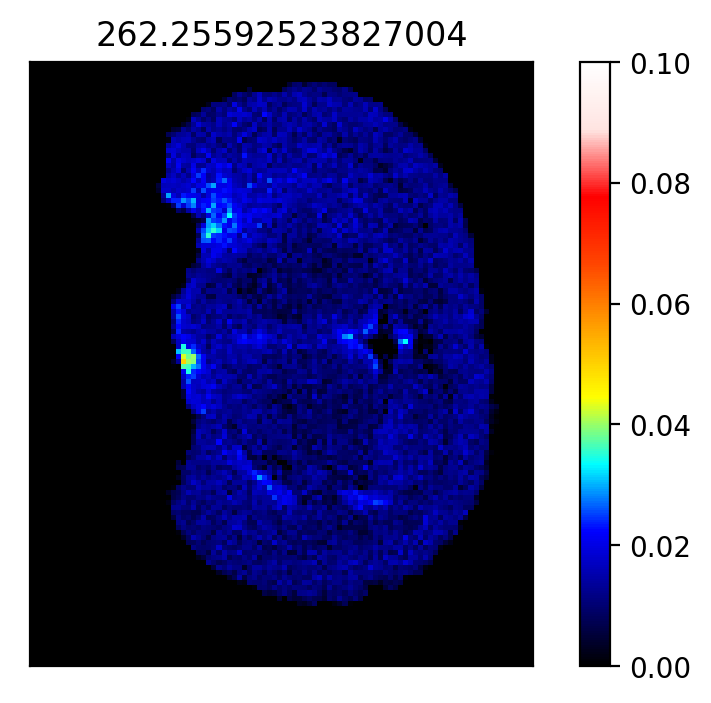

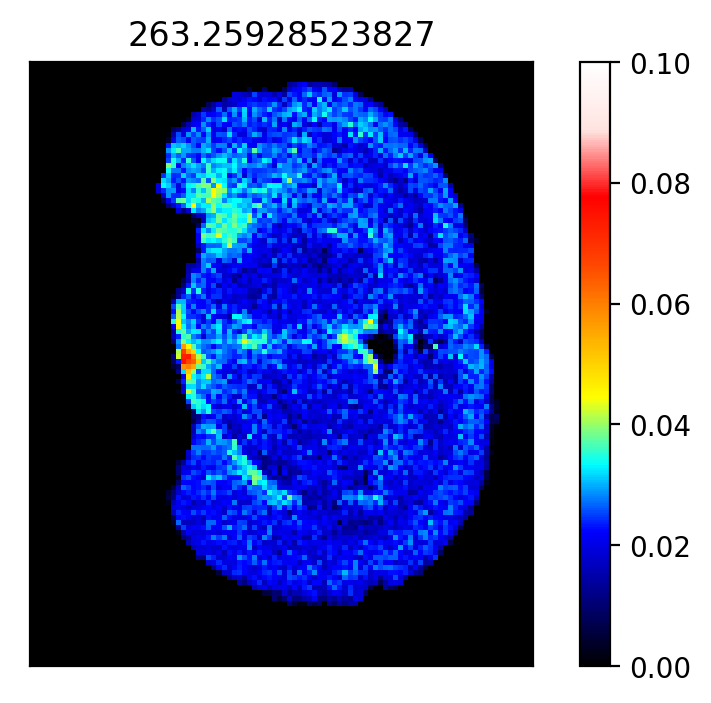

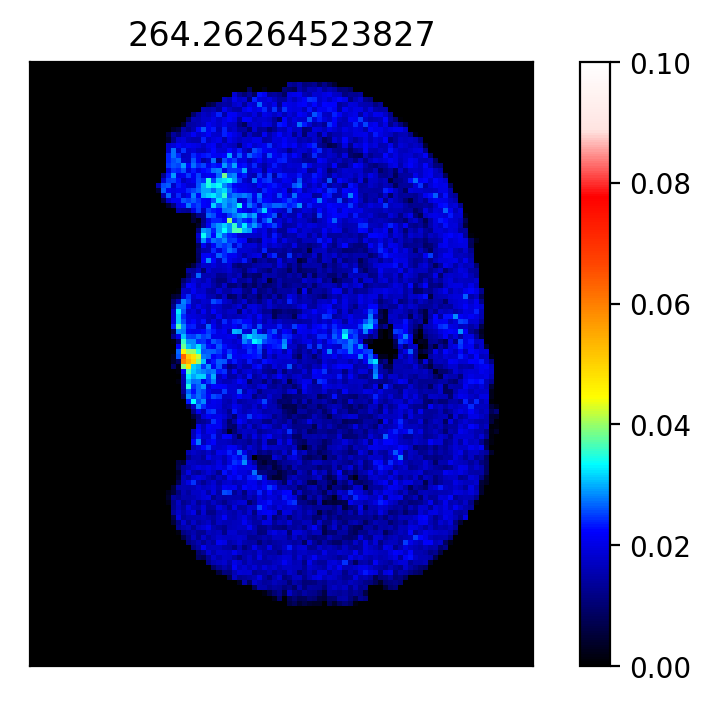

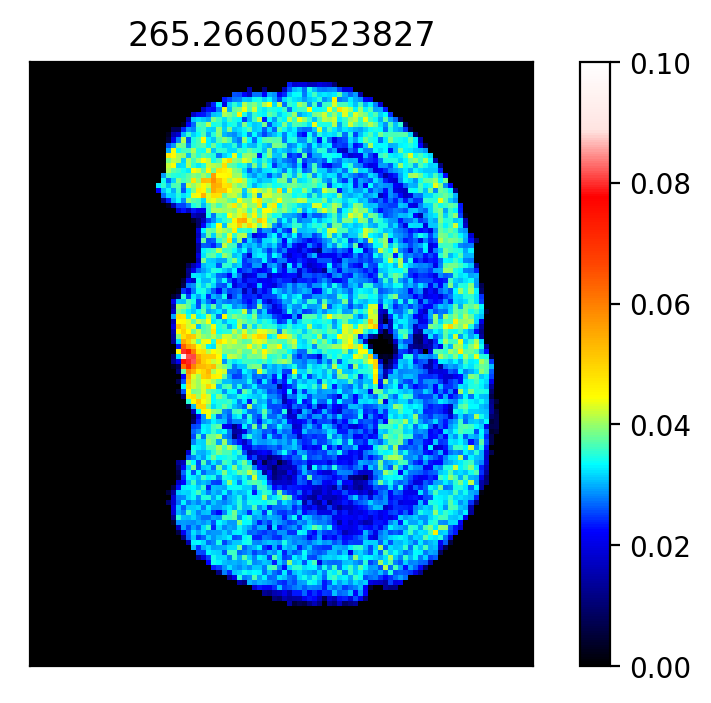

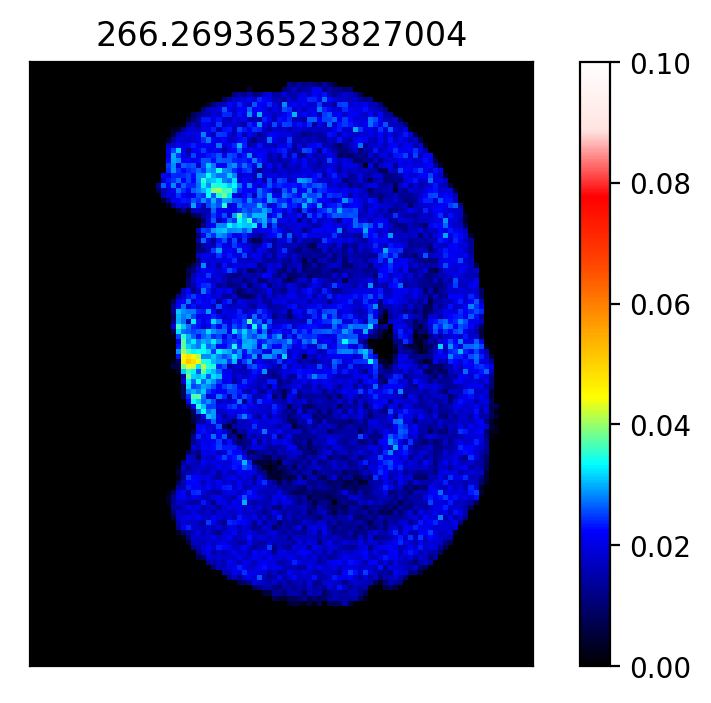

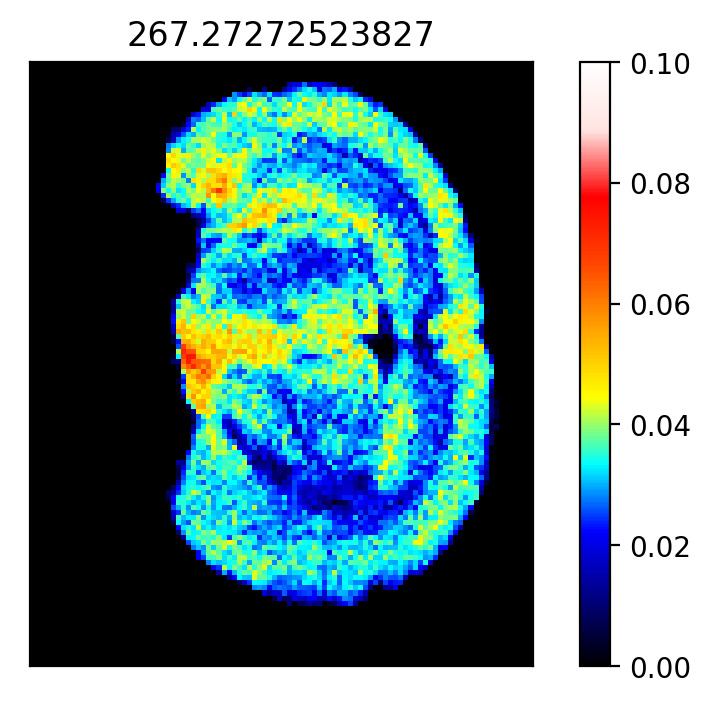

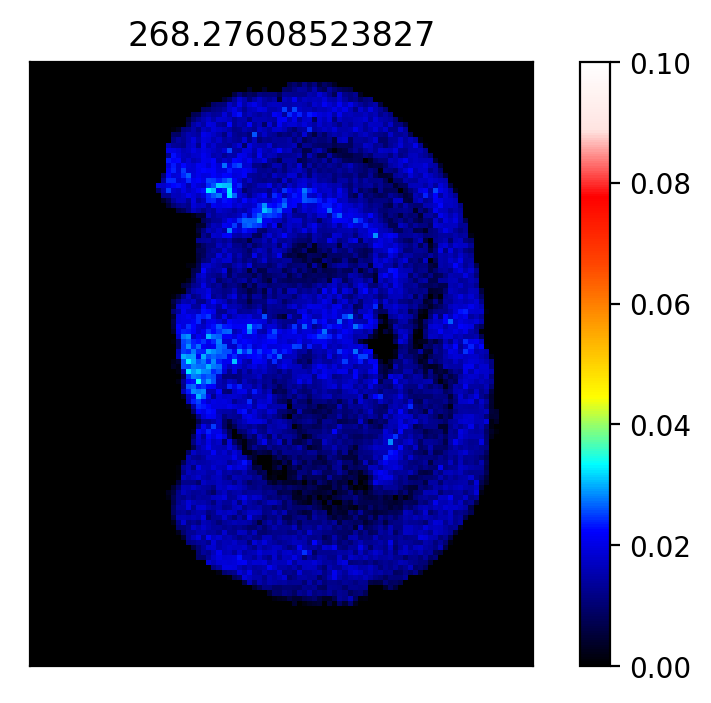

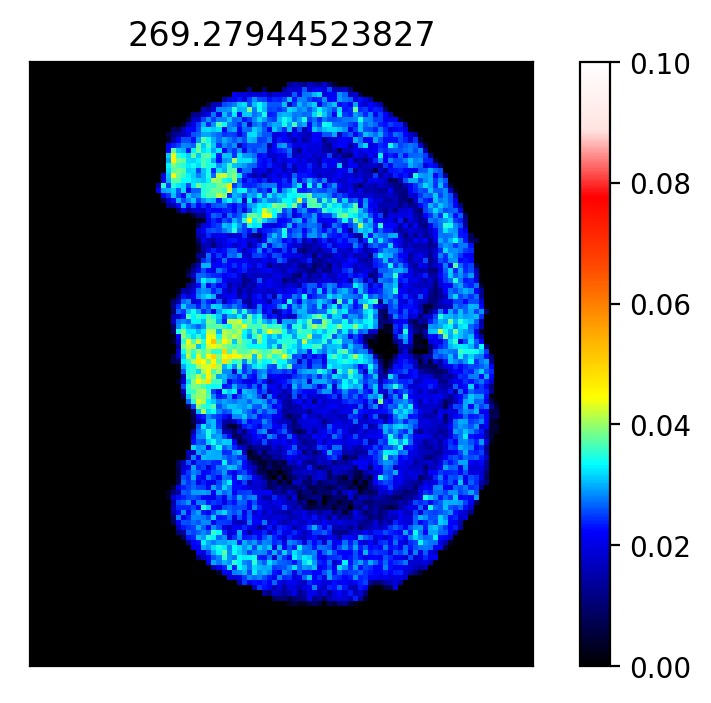

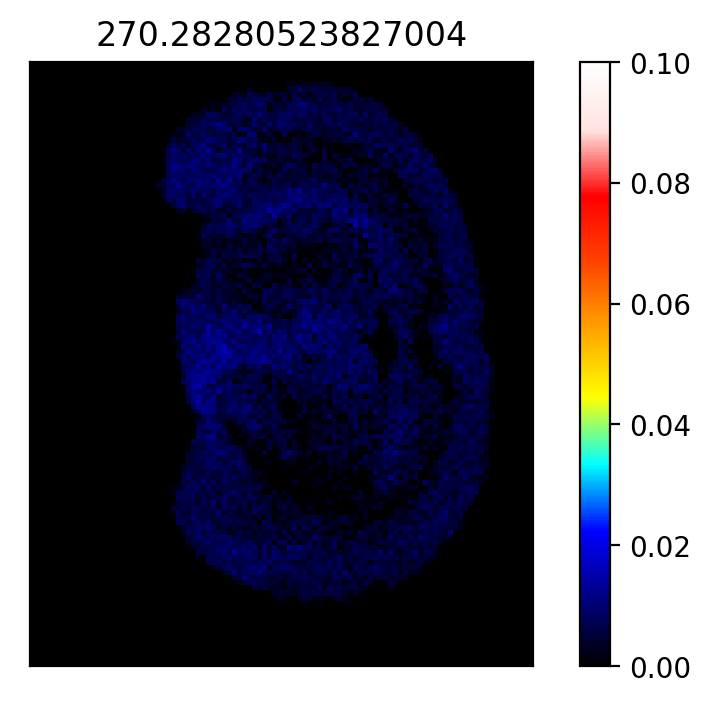

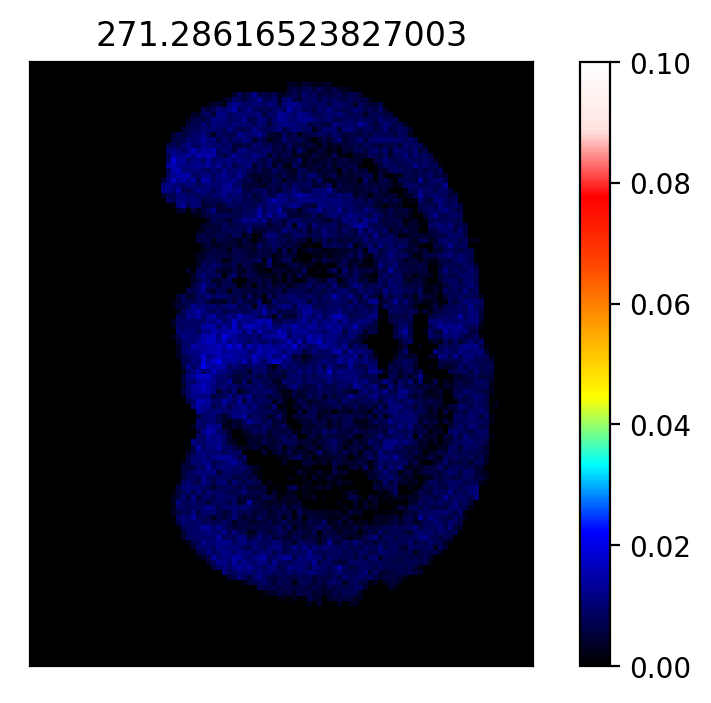

In [15]:
#calculation labeling pattern images and save result
goodInds = [x for x in range(len(msi.data_tensor)) if x not in [3,4,5]]

iso_tensor = SIMSIToolBox.normalizeTensor(msi.data_tensor[goodInds])
counter = 0
maxLabeling = [0.1 for _ in range(len(goodInds))]
maxLabeling[0] = 1.0
maxLabeling[1] = 1.0

for mz,image in zip(np.array(msi.targets)[goodInds],iso_tensor):
    plt.figure()
    SIMSIToolBox.showImage(image,cmap=colormap)
    plt.title(mz)

    plt.clim(0,maxLabeling[counter])
    norm = plt.Normalize(vmin=0, vmax=maxLabeling[counter])
    norm = colormap(norm(image))
    for row in range(norm.shape[0]):
        for col in range(norm.shape[1]):
            if msi.imageBoundary[row,col] < .5:
                norm[row,col,3] = 0
    plt.imsave(datadir + file.replace(".csv","") + "/M" + str(goodInds[counter]) + ".png",norm)#,cmap=colormap)
    counter += 1
    plt.savefig(datadir + file.replace(".csv","") + "/iso_with_colorbar.png")



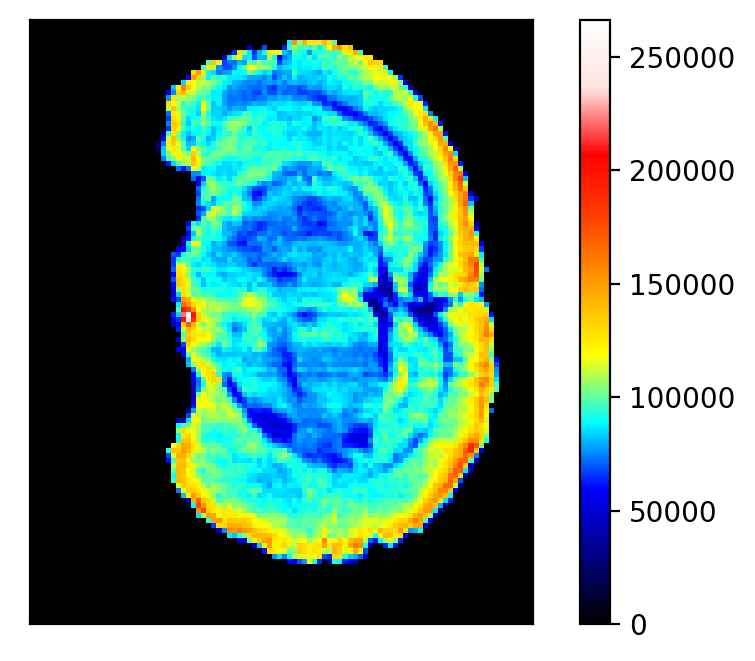

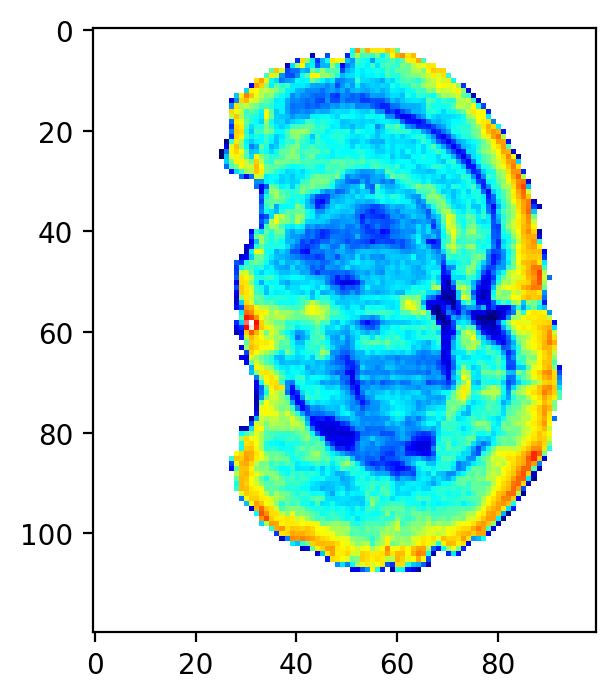

<Figure size 1200x800 with 0 Axes>

In [17]:
poolSize = np.sum(msi.data_tensor[goodInds],axis=0)
SIMSIToolBox.showImage(poolSize,cmap=colormap)

norm = plt.Normalize(vmin=poolSize.min(),vmax = poolSize.max())
norm = colormap(norm(poolSize))
for row in range(norm.shape[0]):
    for col in range(norm.shape[1]):
        if msi.imageBoundary[row,col] < .5:
            norm[row,col,3] = 0

plt.imsave(datadir + file.replace(".csv","") + "/poolsize.png",norm)
plt.figure()
plt.imshow(norm)

plt.figure()

plt.savefig(datadir + file.replace(".csv","") + "/poolsize_with_colorbar.png")

(120, 100, 4)


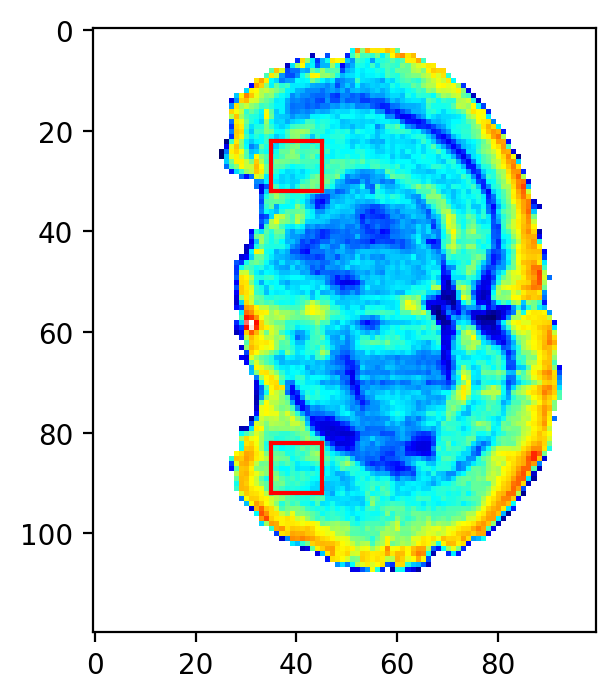

In [20]:
#add boxes
size = 10

box1x = 35
box1y = 22

box2x = 35
box2y = 82

def plotBox(xmin,ymin,color):
    xmax = xmin + size
    ymax = ymin + size
    plt.plot([xmin,xmax],[ymin,ymin],color)
    plt.plot([xmin,xmax],[ymax,ymax],color)
    plt.plot([xmin,xmin],[ymin,ymax],color)
    plt.plot([xmax,xmax],[ymin,ymax],color)
    
def addBox(xmin,ymin,color,image):
    image = deepcopy(image)
    xmax = xmin + size
    ymax = ymin + size
    image[xmin:xmax+1,ymin] = color
    image[xmin:xmax+1,ymax] = color
    image[xmin,ymin:ymax+1] = color
    image[xmax,ymin:ymax+1] = color
    return image
    

plt.imshow(norm)
    
plotBox(box1x,box1y,"red")
plotBox(box2x,box2y,"red")

print(norm.shape)

img = addBox(box1y,box1x,(1.0,0,0,1.0),norm)
img = addBox(box2y,box2x,(1.0,0,0,1.0),img)


plt.imsave(datadir + file.replace(".csv","") + "/poolsize.png",img)


In [21]:
# sb.set_theme(style="white",font_scale=.5)

# def extractLabelingPattern(data,xmin,ymin):
#     xmax = xmin + size
#     ymax = ymin + size
#     roi = []
#     for x in range(xmin,xmax+1):
#         for y in range(ymin,ymax+1):
#             roi.append(data[goodInds,x,y])
#     roi = np.array(roi)
    
#     df  = {}
#     for row in roi:
#         for x in range(len(goodInds)):
#            df[len(df)] = {"isotopologue":"M"+str(goodInds[x]),"Isotopologue Fraction":row[x]}

#     df = pd.DataFrame.from_dict(df,orient="index")

#     return df

# df = extractLabelingPattern(iso_tensor,box1y,box1x)

# fig,ax = plt.subplots(figsize=(5,4))

# ax.spines['right'].set_visible(False)
# ax.spines['top'].set_visible(False)


# sb.barplot(data=df,x="isotopologue",y="Isotopologue Fraction",capsize=.1,color="dimgrey",errwidth=1.5)
# plt.ylim((0,maxLabeling))
# plt.xlabel("")
# plt.tight_layout()
# plt.savefig(datadir + file.replace(".csv","") + "/box1.png")

# fig,ax = plt.subplots(figsize=(5,4))
# ax.spines['right'].set_visible(False)
# ax.spines['top'].set_visible(False)

# df = extractLabelingPattern(iso_tensor,box2y,box2x)

# sb.barplot(data=df,x="isotopologue",y="Isotopologue Fraction",capsize=.1,color="dimgrey",errwidth=1.5)
# plt.ylim((0,maxLabeling))
# plt.xlabel("")
# plt.tight_layout()
# plt.savefig(datadir + file.replace(".csv","") + "/box2.png")


In [22]:

# def extractLabelingPattern(data,xmin,ymin):
#     xmax = xmin + size
#     ymax = ymin + size
#     roi = []
#     for x in range(xmin,xmax+1):
#         for y in range(ymin,ymax+1):
#             roi.append(data[goodInds,x,y])
#     roi = np.array(roi)
    
#     df  = {}
#     for row in roi:
#         df[len(df)] = {"isotopologue":"unlabeled","Isotopologue Fraction":row[0]}
#         df[len(df)] = {"isotopologue":"labeled","Isotopologue Fraction":np.sum(row[1:])}

#     df = pd.DataFrame.from_dict(df,orient="index")

#     return df

# df = extractLabelingPattern(iso_tensor,box1y,box1x)

# fig,ax = plt.subplots(figsize=(5,4))

# ax.spines['right'].set_visible(False)
# ax.spines['top'].set_visible(False)


# sb.barplot(data=df,x="isotopologue",y="Isotopologue Fraction",capsize=.1,color="dimgrey",errwidth=1.5)
# plt.ylim((0,maxLabeling))
# plt.xlabel("")
# plt.tight_layout()
# plt.savefig(datadir + file.replace(".csv","") + "/box1.png")

# fig,ax = plt.subplots(figsize=(5,4))
# ax.spines['right'].set_visible(False)
# ax.spines['top'].set_visible(False)

# df = extractLabelingPattern(iso_tensor,box2y,box2x)

# sb.barplot(data=df,x="isotopologue",y="Isotopologue Fraction",capsize=.1,color="dimgrey",errwidth=1.5)
# plt.ylim((0,maxLabeling))
# plt.xlabel("")
# plt.tight_layout()
# plt.savefig(datadir + file.replace(".csv","") + "/box2.png")


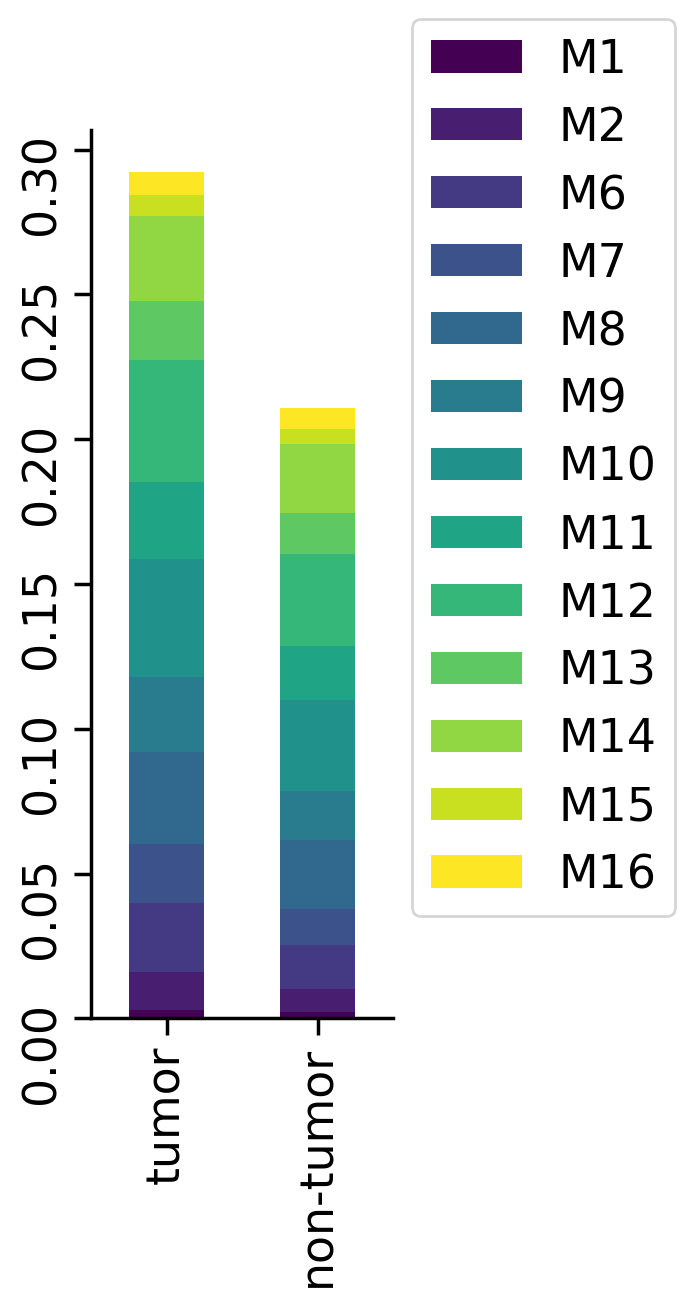

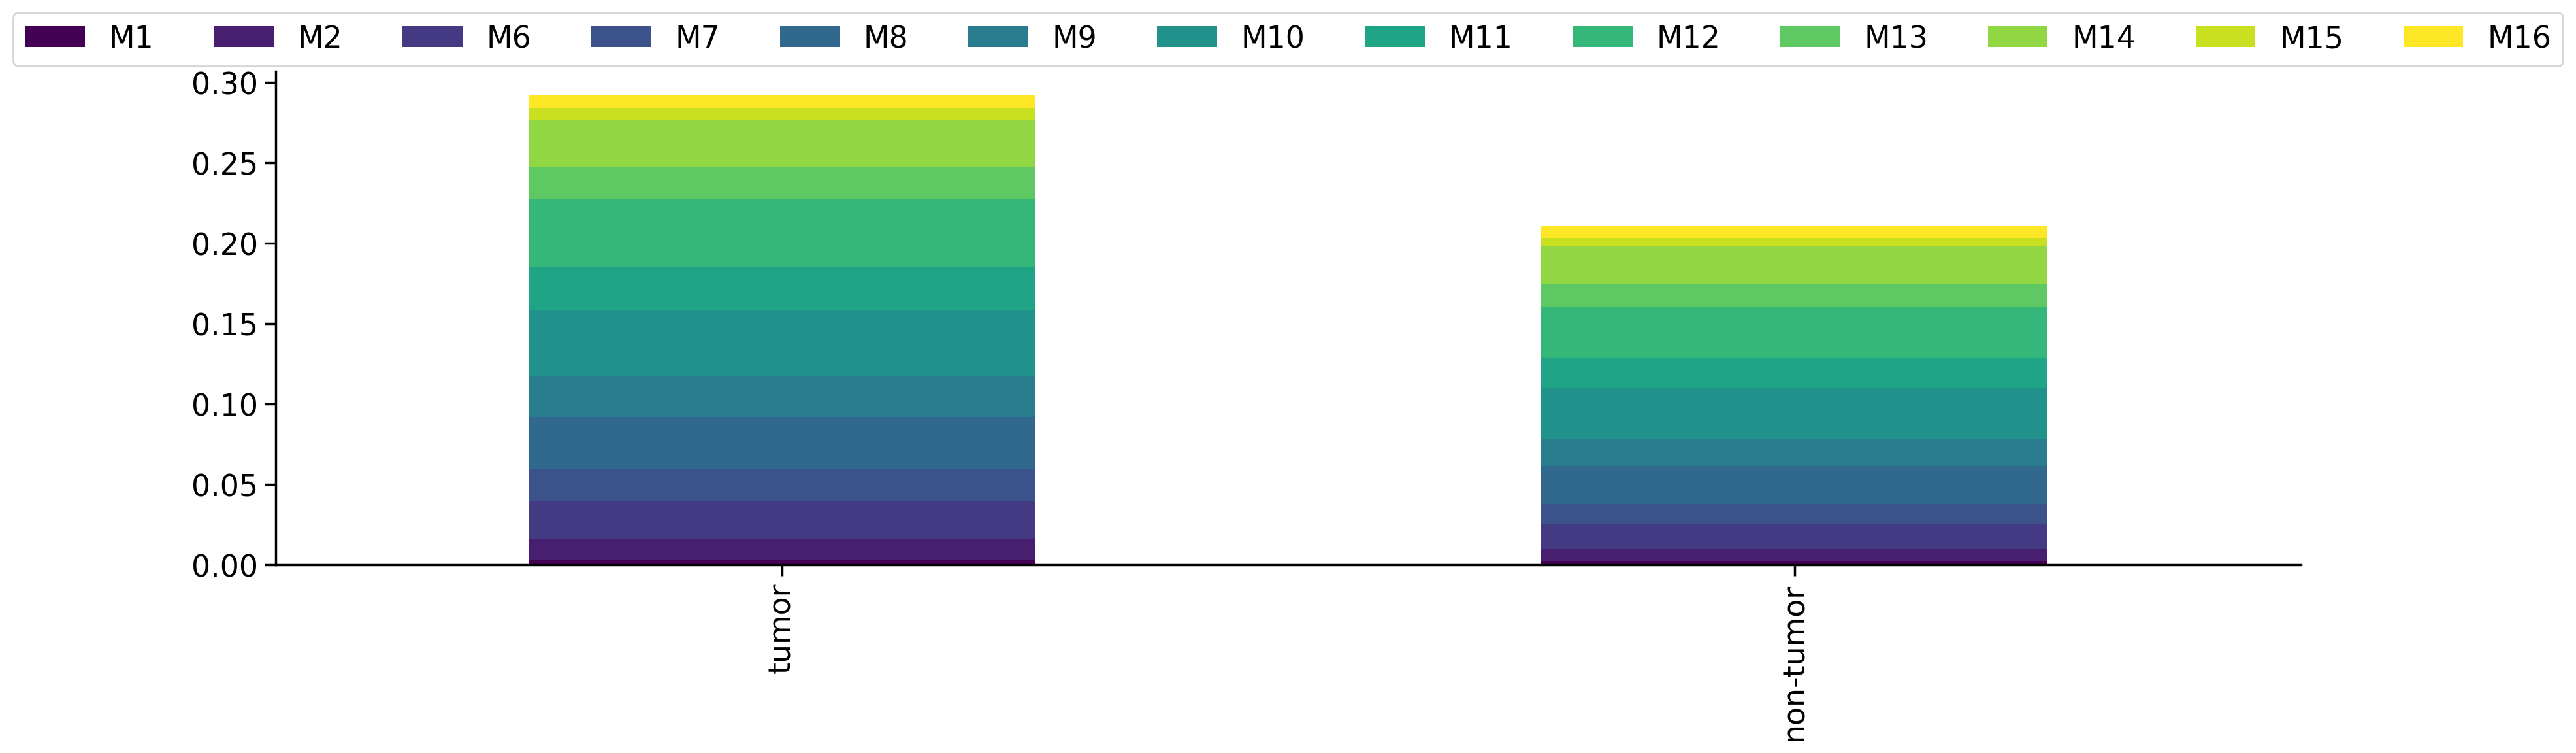

In [23]:
sb.set_theme(font_scale=1.5,style={'ytick.left': True})


def extractLabelingPattern(data,xmin,ymin):
    xmax = xmin + size
    ymax = ymin + size
    roi = []
    for x in range(xmin,xmax+1):
        for y in range(ymin,ymax+1):
            roi.append(data[:,x,y])
    roi = np.array(roi)
    
    roi = roi.mean(axis=0)
    
    df  = {}
    for x in range(len(goodInds)):
       df[len(df)] = {"isotopologue":"M"+str(goodInds[x]),"Isotopologue Fraction":roi[x]}

    df = pd.DataFrame.from_dict(df,orient="index")
    
    df = df.set_index("isotopologue")

    return df

df = extractLabelingPattern(iso_tensor,box1y,box1x)

fig,ax = plt.subplots(figsize=(5,7))

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

df = df.rename(mapper={"Isotopologue Fraction":"tumor"},axis=1)

df2 = extractLabelingPattern(iso_tensor,box2y,box2x)

df2 = df2.rename(mapper={"Isotopologue Fraction":"non-tumor"},axis=1)

df = pd.concat((df,df2),axis=1,ignore_index=False).transpose()

# df.plot(kind='bar', stacked=True,ax=ax,cmap="viridis")

# plt.legend(loc="upper center", bbox_to_anchor=(1.5, 1.15))

# fig,ax = plt.subplots(figsize=(5,4))

# ax.spines['right'].set_visible(False)
# ax.spines['top'].set_visible(False)

df = df[[x for x in df.columns.values if x != "M0"]]

df.plot(kind='bar', stacked=True,ax=ax,cmap="viridis")

plt.legend(loc="upper center", bbox_to_anchor=(1.5, 1.15) )

plt.yticks([0.0,0.05,0.1,0.15,0.2,0.25,0.30],rotation=90)

plt.tight_layout()

plt.savefig(datadir + file.replace(".csv","") + "/bar_boxes.png")


fig,ax = plt.subplots(figsize=(20,5))

df.plot(kind='bar', stacked=True,ax=ax,cmap="viridis")

plt.legend(loc="upper center", bbox_to_anchor=(.5, 1.15) ,ncol=len(df.columns))

#plt.colorbar()

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

plt.savefig(datadir + file.replace(".csv","") + "/bar_legend.png")

# sb.barplot(data=df,x="isotopologue",y="Isotopologue Fraction",capsize=.1,color="dimgrey",errwidth=1.5)
# plt.ylim((0,maxLabeling))
# plt.xlabel("")
# plt.tight_layout()
# plt.savefig(datadir + file.replace(".csv","") + "/box1.png")

# fig,ax = plt.subplots(figsize=(5,4))
# ax.spines['right'].set_visible(False)
# ax.spines['top'].set_visible(False)

# df = extractLabelingPattern(iso_tensor,box2y,box2x)

# sb.barplot(data=df,x="isotopologue",y="Isotopologue Fraction",capsize=.1,color="dimgrey",errwidth=1.5)
# plt.ylim((0,maxLabeling))
# plt.xlabel("")
# plt.tight_layout()
# plt.savefig(datadir + file.replace(".csv","") + "/box2.png")


# sb.reset_orig()

# plot_df = pd.DataFrame.from_dict(compositions,orient="index")
# cols = list(plot_df.columns.values)
# cols.sort(key=lambda x: np.sum(plot_df[x].values),reverse=True)
# plot_df = plot_df[cols[:9]]
# plot_df["other"] = [1-np.sum(row.values) for index,row in plot_df.iterrows()]
# plot_df.plot(kind='bar', stacked=True)
# plt.legend(loc="upper center", bbox_to_anchor=(1.5, 1.15))
# plot_df

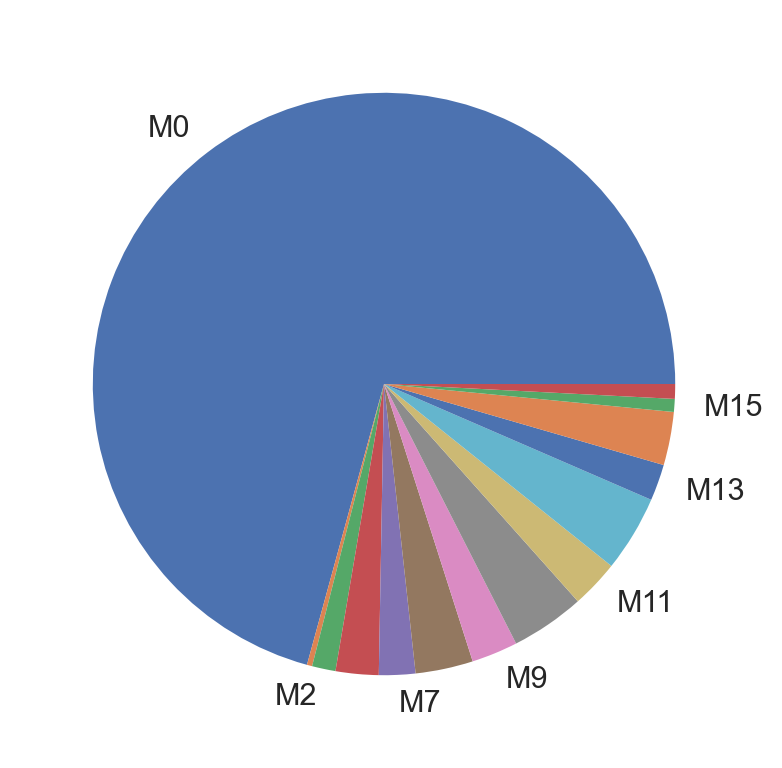

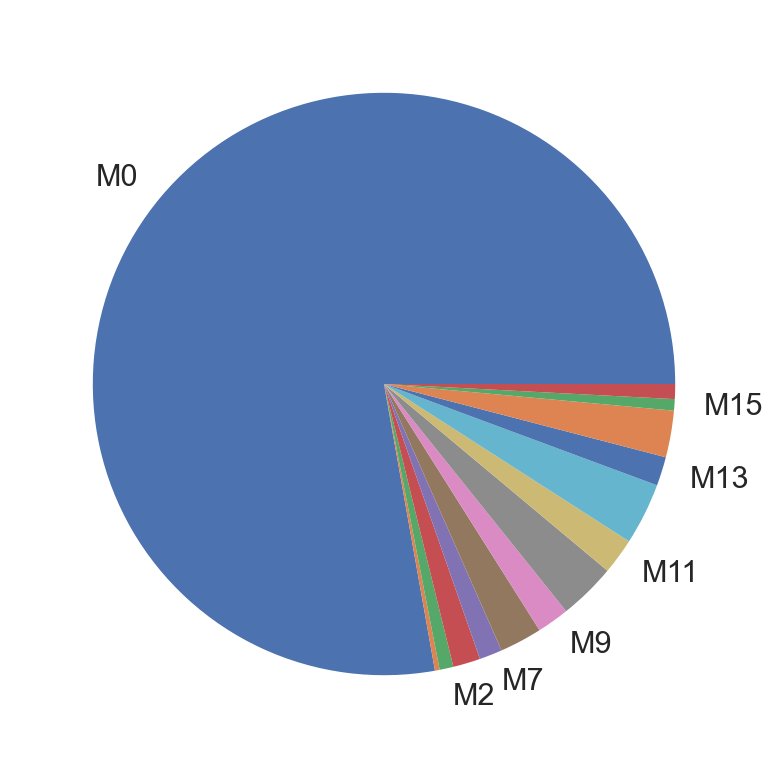

In [24]:
sb.set_theme(style="white",font_scale=1.0)

def extractLabelingPattern(data,xmin,ymin):
    xmax = xmin + size
    ymax = ymin + size
    roi = []
    for x in range(xmin,xmax+1):
        for y in range(ymin,ymax+1):
            roi.append(data[goodInds,x,y])
    roi = np.array(roi)
    
    roi = roi.mean(axis=0)
        
    return roi
    

roi = extractLabelingPattern(msi.data_tensor,box1y,box1x)

fig,ax = plt.subplots(figsize=(5,4))

labels = ["M"+str(x) for x in goodInds]

for x in range(1,len(goodInds),2):
    labels[x] = ""

plt.pie(x=roi,labels=labels,explode=[0] + [0 for x in range(len(goodInds)-1)],wedgeprops = {'linewidth': 0} )

plt.tight_layout()
plt.savefig(datadir + file.replace(".csv","") + "/box1.png")

fig,ax = plt.subplots(figsize=(5,4))

roi = extractLabelingPattern(msi.data_tensor,box2y,box2x)

plt.pie(x=roi,labels=labels,explode=[0] + [0 for x in range(len(goodInds)-1)],wedgeprops = {'linewidth': 0} )

plt.tight_layout()
plt.savefig(datadir + file.replace(".csv","") + "/box2.png")


In [45]:
file = files[0]
print(file)
m0Mz,mzsOI,numCarbons = SIMSIToolBox.getMzsOfIsotopologues(formula,elementOfInterest="C")
msi = SIMSIToolBox.MSIData(mzsOI,ppm=ppmThresh,numCores = num_cores,intensityCutoff=0)
df = pd.read_csv(datadir + file,index_col=0)
msi.from_pandas(df,polarity)

20210223_02_100w120h_13CtumorBrain2_009109H_01 009109H_1.csv


In [26]:
# if __name__ == "__main__":
#     filt = "GB"
#     convSquare = 3
#     msi.smoothData(filt,convSquare)

In [46]:
msi.data_tensor[3] = np.zeros(msi.data_tensor[3].shape)
msi.data_tensor[4] = np.zeros(msi.data_tensor[4].shape)
msi.data_tensor[5] = np.zeros(msi.data_tensor[5].shape)

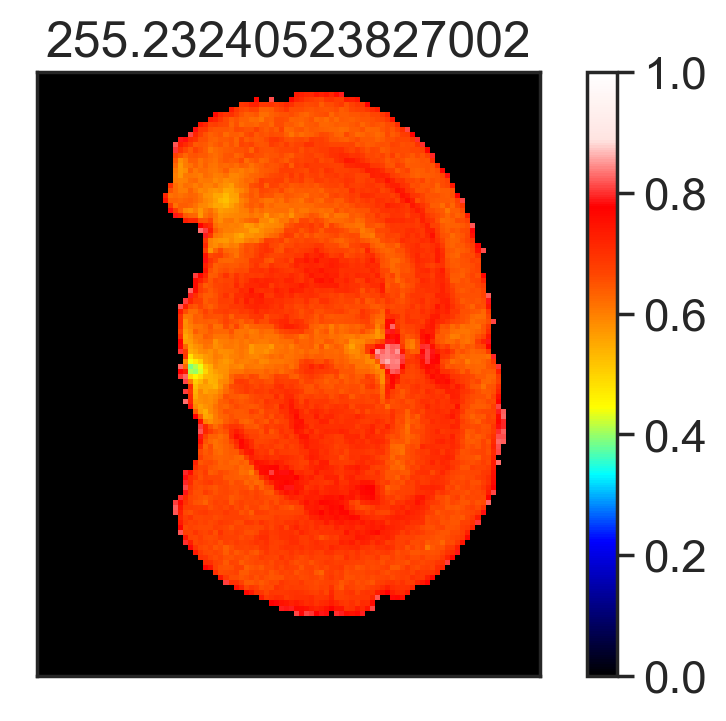

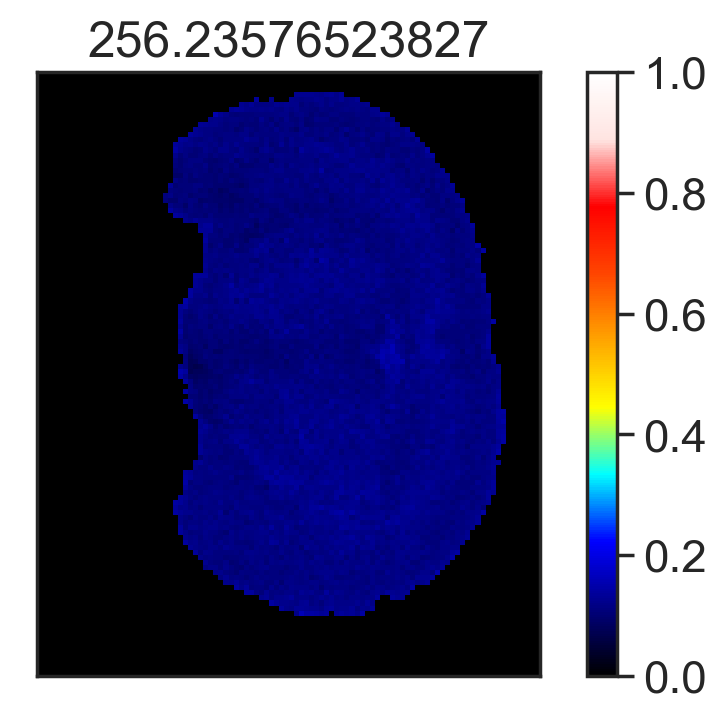

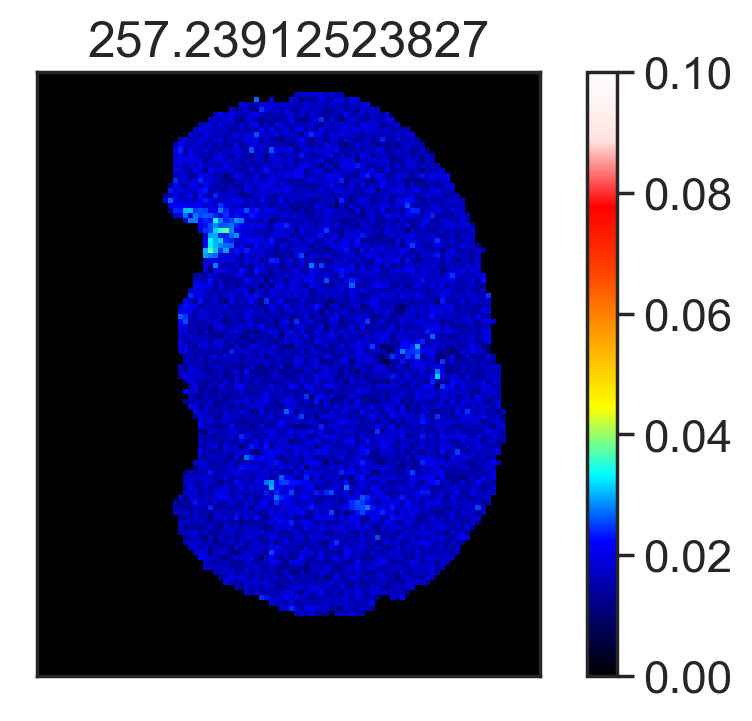

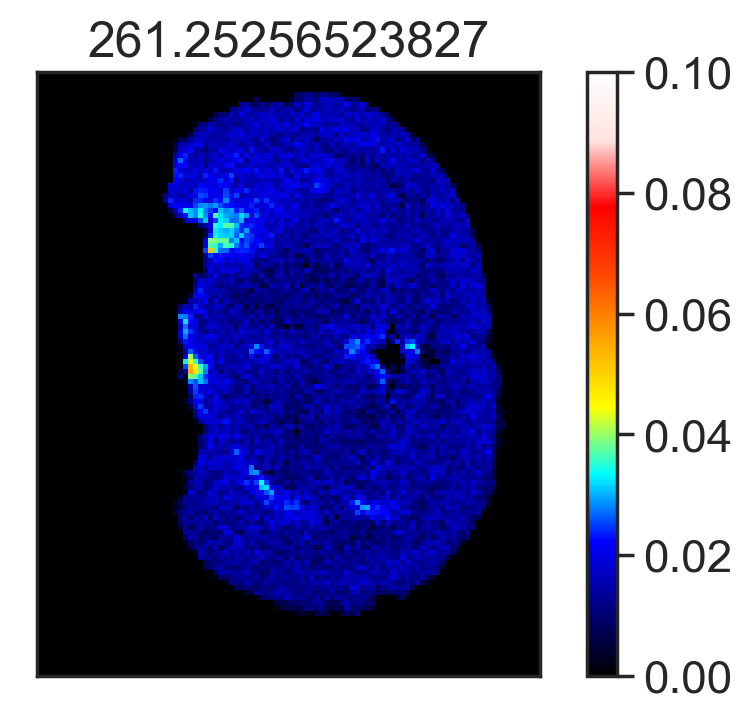

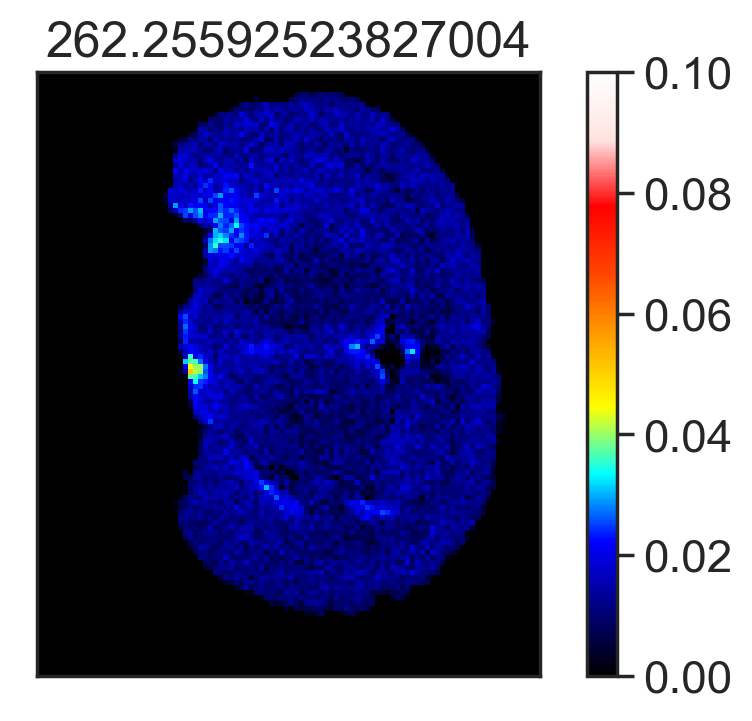

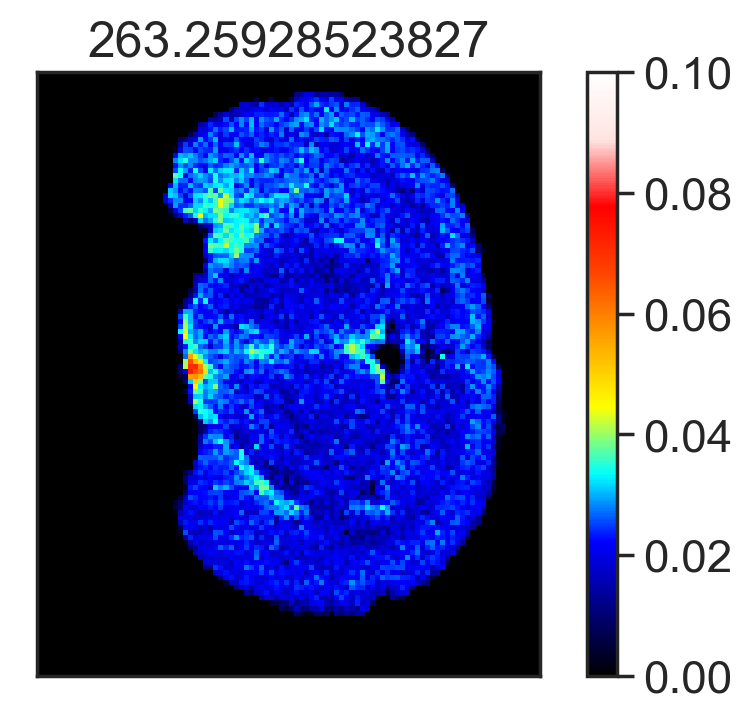

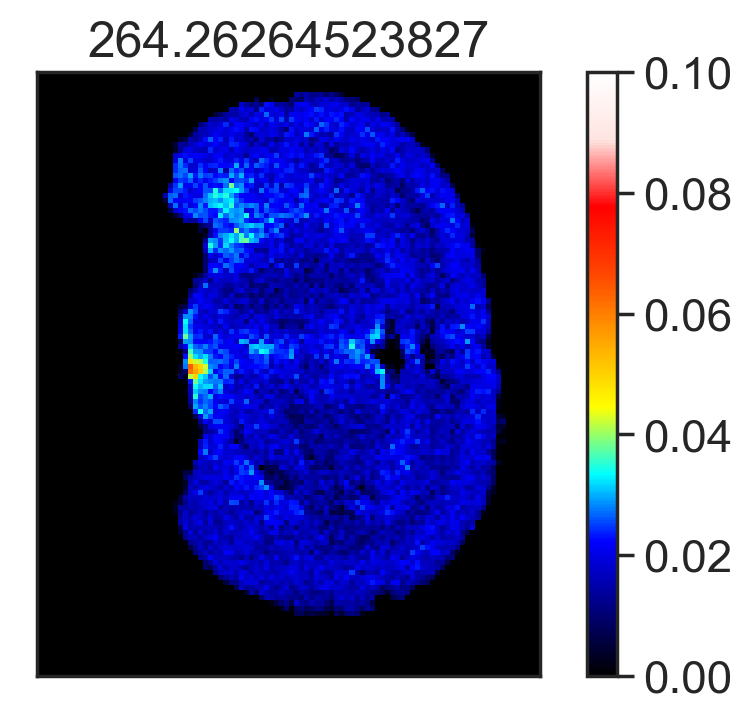

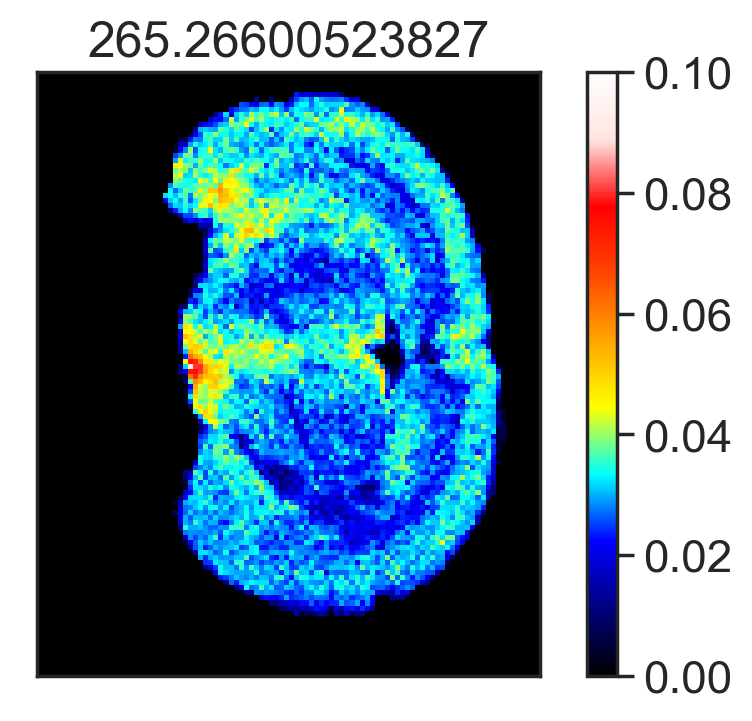

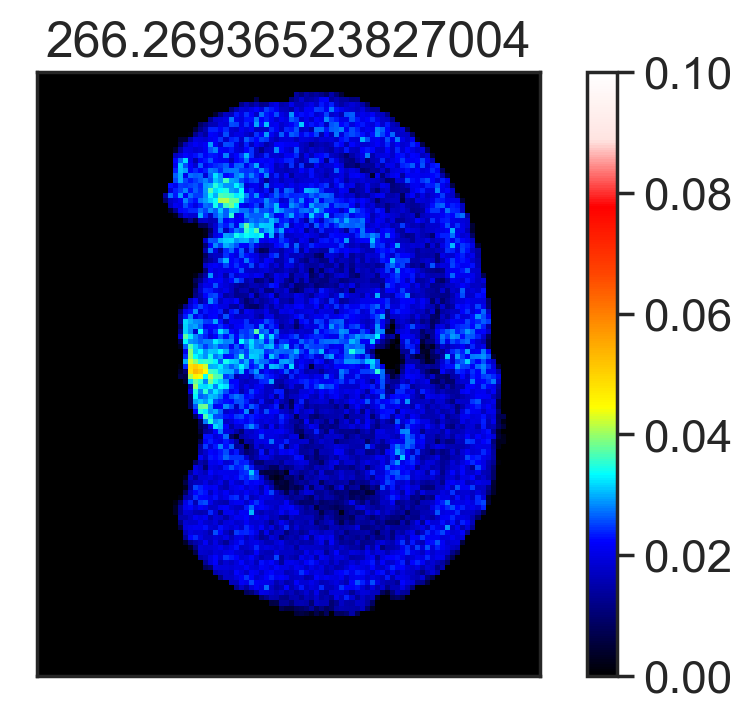

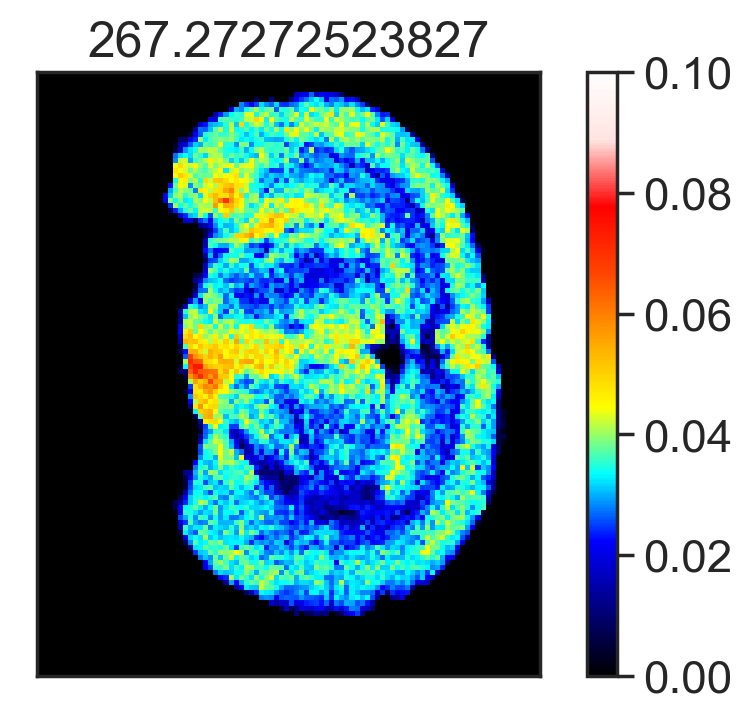

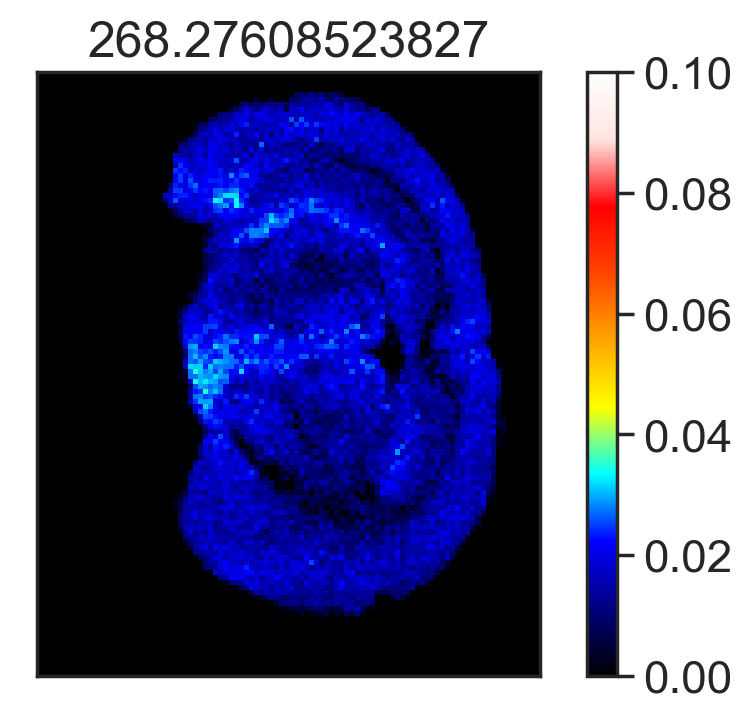

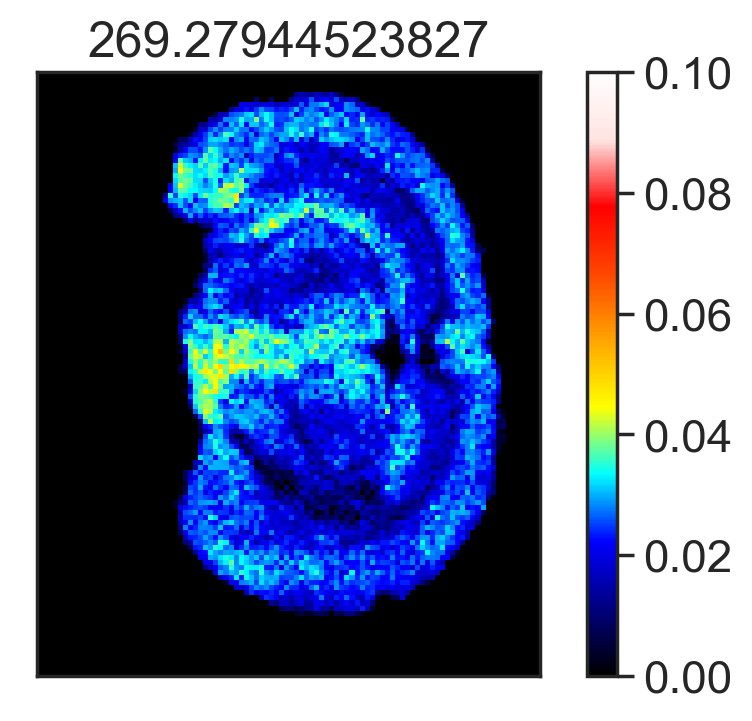

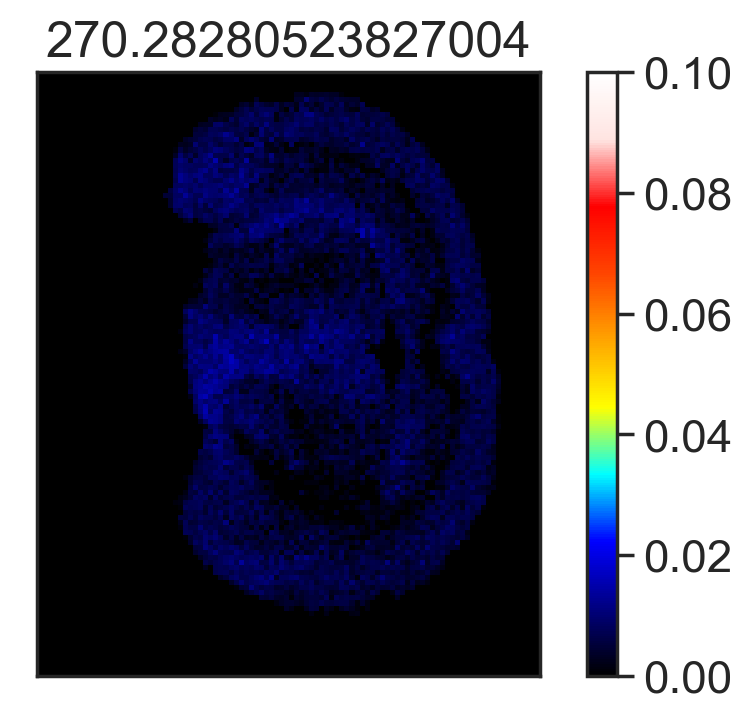

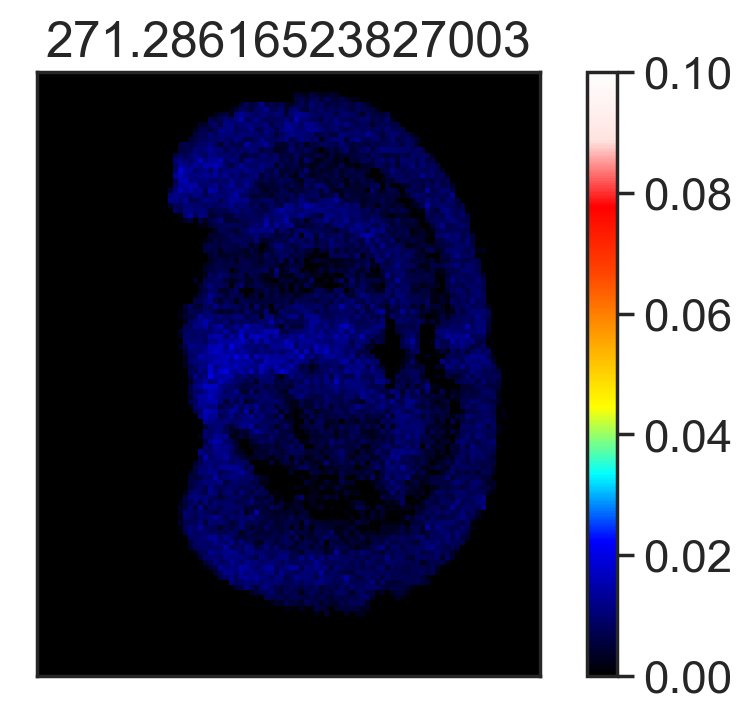

In [48]:
#calculation labeling pattern images and save result
goodInds = [x for x in range(len(msi.data_tensor)) if x not in [3,4,5]]

iso_tensor = SIMSIToolBox.normalizeTensor(msi.data_tensor[goodInds])
counter = 0
maxLabeling = [0.1 for _ in range(len(goodInds))]
maxLabeling[0] = 1.0
maxLabeling[1] = 1.0
for mz,image in zip(np.array(msi.targets)[goodInds],iso_tensor):
    plt.figure()
    SIMSIToolBox.showImage(image,cmap=colormap)
    plt.title(mz)

    plt.clim(0,maxLabeling[counter])
    norm = plt.Normalize(vmin=0, vmax=maxLabeling[counter])
    norm = colormap(norm(image))
    for row in range(norm.shape[0]):
        for col in range(norm.shape[1]):
            if msi.imageBoundary[row,col] < .5:
                norm[row,col,3] = 0
    plt.imsave(datadir + file.replace(".csv","") + "/M" + str(goodInds[counter]) + ".png",norm)#,cmap=colormap)
    counter += 1
    plt.savefig(datadir + file.replace(".csv","") + "/iso_with_colorbar.png")



In [49]:
if __name__ == "__main__":
    fluxImageG,fluxImageD,fluxImageT0,fluxImageT1,fluxImageT2,T_founds,P_trues,P_preds,numFounds,errs,errors = msi.runISA()

Running ISA |██████████████████████████████████████████████████| 100.0% 


In [50]:
os.mkdir(datadir + file.replace(".csv","/"))

FileExistsError: [WinError 183] Cannot create a file when that file already exists: 'X:/MSI_Shared_Data/13CImagingManuscript/raw_data/imzmls/subset_data/NA_corrected_data/manuscript_figs/figure4/20210223_02_100w120h_13CtumorBrain2_009109H_01 009109H_1/'

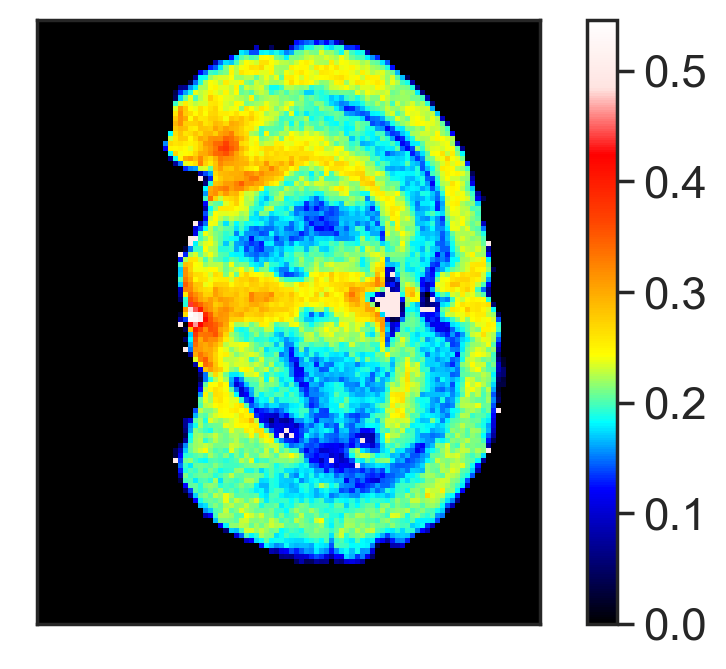

In [51]:
SIMSIToolBox.showImage(fluxImageG,cmap=colormap)

norm = plt.Normalize(vmin=fluxImageG.min(),vmax=fluxImageG.max())
norm = colormap(norm(fluxImageG))
for row in range(norm.shape[0]):
    for col in range(norm.shape[1]):
        if msi.imageBoundary[row,col] < .5:
            norm[row,col,3] = 0
plt.imsave(datadir + file.replace(".csv","") + "/gt.png",norm)


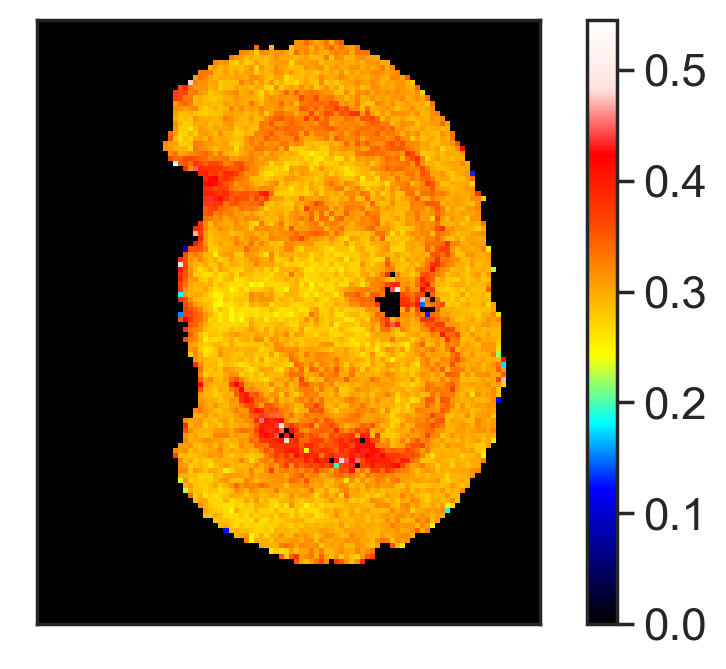

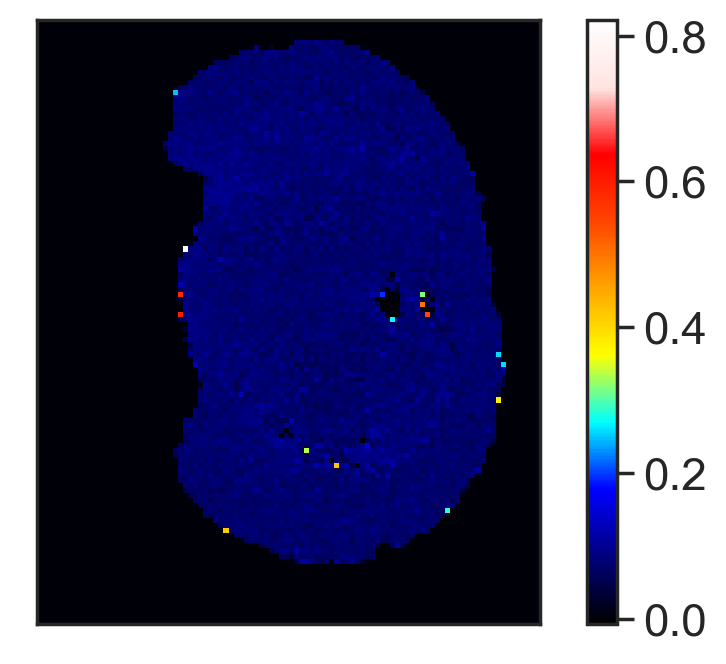

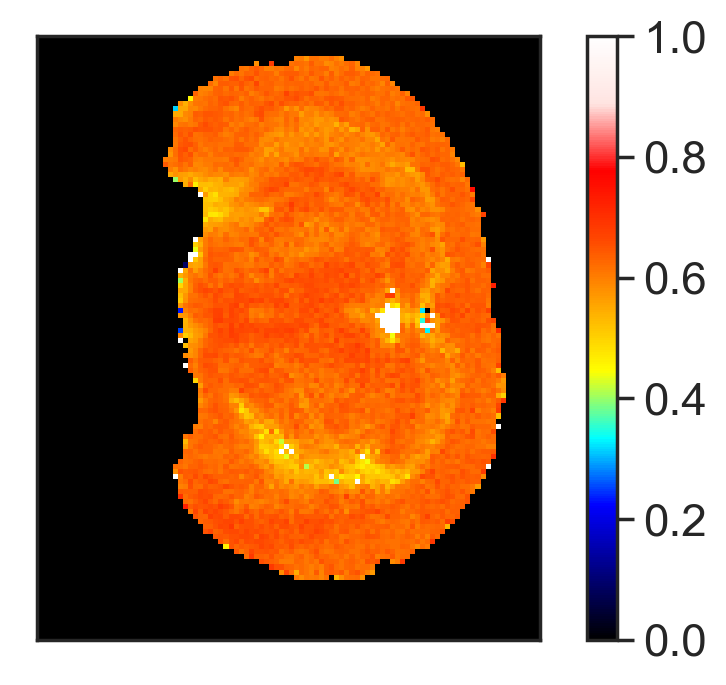

In [52]:
for im,label in zip([fluxImageT0,fluxImageT1,fluxImageT2],["X0","X1","X2"]):
    plt.figure()
    SIMSIToolBox.showImage(im,cmap=colormap)

    norm = plt.Normalize(vmin=im.min(),vmax=im.max())
    norm = colormap(norm(im))
    for row in range(norm.shape[0]):
        for col in range(norm.shape[1]):
            if msi.imageBoundary[row,col] < .5:
                norm[row,col,3] = 0
    plt.imsave(datadir + file.replace(".csv","") + "/" + label +".png",norm)
